In [1]:
!pip install transformers torch datasets rouge-score nltk streamlit pyngrok
!pip install accelerate -U

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 118.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.2 MB/s eta 0:00:0000:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-no

In [2]:
# Import libraries and setup
import pandas as pd
import numpy as np
import torch
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

print("Setup complete!")



2025-06-21 10:47:02.246573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750502822.467748      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750502822.528973      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete!


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data Loading and Visualization

In [3]:
dataset_path = '/kaggle/input/medquad-csv/medquad.csv'
df = pd.read_csv(dataset_path)

# Display info
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns}")
print("\nFirst few rows:")
print(df.head())

print(f"Questions: {len(df)} total")
print(f"Sample question: {df['question'].iloc[0]}")
print(f"Sample answer: {df['answer'].iloc[0][:100]}...")


Dataset shape: (16412, 4)
Columns: Index(['question', 'answer', 'source', 'focus_area'], dtype='object')

First few rows:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Questions: 16412 total
Sample question: What is (are) Glaucoma ?
Sample answer

# Preprocessing and Analysis

Original dataset size: 16407
Reduced dataset size for memory: 2000


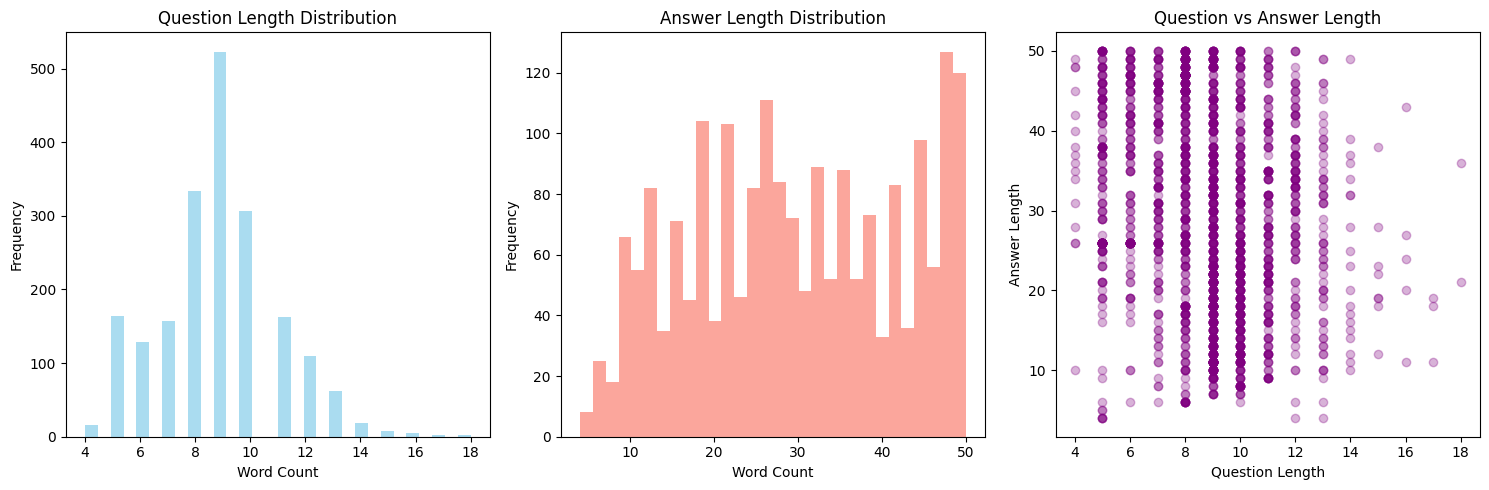

In [4]:
# Clean the data
df = df.dropna(subset=['question', 'answer'])
df['question'] = df['question'].astype(str)
df['answer'] = df['answer'].astype(str)

# Calculate word lengths
df['q_word_len'] = df['question'].apply(lambda x: len(x.split()))
df['a_word_len'] = df['answer'].apply(lambda x: len(x.split()))

# Memory Optimization
print(f"Original dataset size: {len(df)}")

# Remove very long entries to save memory
df = df[(df['q_word_len'] >= 3) & (df['q_word_len'] <= 30)]
df = df[(df['a_word_len'] >= 3) & (df['a_word_len'] <= 50)]  # Shorter answers

# Use only a subset for training
df = df.head(2000)
print(f"Reduced dataset size for memory: {len(df)}")

# Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['q_word_len'], bins=30, color='skyblue', alpha=0.7)
plt.title('Question Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['a_word_len'], bins=30, color='salmon', alpha=0.7)
plt.title('Answer Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.scatter(df['q_word_len'], df['a_word_len'], alpha=0.3, color='purple')
plt.title('Question vs Answer Length')
plt.xlabel('Question Length')
plt.ylabel('Answer Length')

plt.tight_layout()
plt.show()


In [5]:
# Data splitting
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Train size: 1400
Validation size: 300
Test size: 300


In [6]:
# Save train, validation, and test sets as CSV files
train_df.to_csv("/kaggle/working/train.csv", index=False)
print("Training set saved as train.csv")

val_df.to_csv("/kaggle/working/val.csv", index=False)
print("Validation set saved as val.csv")

test_df.to_csv("/kaggle/working/test.csv", index=False)
print("Test set saved as test.csv")


Training set saved as train.csv
Validation set saved as val.csv
Test set saved as test.csv


In [24]:
preprocessing_code = '''
import pandas as pd
import torch
from transformers import T5Tokenizer
import os

# Use FLAN tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")

# Sequence lengths (adjusted for short QA)
max_input_length = 48
max_target_length = 48

def clean_and_filter(df):
    df = df.dropna(subset=['question', 'answer'])
    df['question'] = df['question'].astype(str)
    df['answer'] = df['answer'].astype(str)
    df['q_word_len'] = df['question'].apply(lambda x: len(x.split()))
    df['a_word_len'] = df['answer'].apply(lambda x: len(x.split()))
    df = df[(df['q_word_len'] >= 3) & (df['q_word_len'] <= 30)]
    df = df[(df['a_word_len'] >= 3) & (df['a_word_len'] <= 50)]
    df = df.head(2000)  # adjust based on memory
    return df

def preprocess_data(df_subset):
    # FLAN uses instruction-style prompts
    inputs = ["Answer the medical question: " + q for q in df_subset['question']]
    targets = [str(a) for a in df_subset['answer']]

    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels"][model_inputs["labels"] == tokenizer.pad_token_id] = -100
    return model_inputs

# Main Execution
if __name__ == "__main__":
    os.makedirs("/kaggle/working/tokenized", exist_ok=True)

    for split in ["train", "val", "test"]:
        try:
            print(f"Processing {split}.csv...")
            df = pd.read_csv(f"/kaggle/working/{split}.csv")
            df = clean_and_filter(df)
            encodings = preprocess_data(df)
            torch.save(encodings, f"/kaggle/working/tokenized/{split}_encodings.pt")
            print(f"Saved {split}_encodings.pt")
        except FileNotFoundError:
            print(f" {split}.csv not found. Skipping.")

'''
# Save to .py file
with open('/kaggle/working/preprocessing.py', 'w') as f:
    f.write(preprocessing_code)

print("Saved as preprocessing.py")


Saved as preprocessing.py


In [25]:
!python /kaggle/working/preprocessing.py


tokenizer_config.json: 100%|███████████████| 2.54k/2.54k [00:00<00:00, 16.1MB/s]
spiece.model: 100%|██████████████████████████| 792k/792k [00:00<00:00, 1.89MB/s]
special_tokens_map.json: 100%|█████████████| 2.20k/2.20k [00:00<00:00, 15.2MB/s]
tokenizer.json: 100%|██████████████████████| 2.42M/2.42M [00:00<00:00, 22.8MB/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Processing train.csv...
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can toke

# Training

In [26]:
training_code = '''
import torch
from torch.utils.data import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
import os

# Disable W&B to avoid logging errors on Kaggle
os.environ["WANDB_MODE"] = "disabled"

# Load FLAN-T5 tokenizer and model
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Load tokenized data
train_encodings = torch.load("/kaggle/working/tokenized/train_encodings.pt")
val_encodings = torch.load("/kaggle/working/tokenized/val_encodings.pt")

# Dataset class
class MedQADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return self.encodings["input_ids"].size(0)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

train_dataset = MedQADataset(train_encodings)
val_dataset = MedQADataset(val_encodings)

# Training config
training_args = TrainingArguments(
    output_dir="/kaggle/working/final_model",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="/kaggle/working/logs",
    fp16=True,
    learning_rate=3e-4,
    evaluation_strategy="epoch",
    lr_scheduler_type="linear",
    logging_steps=20,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
print("Training FLAN-T5-small model...")
trainer.train()

# Save model
model.save_pretrained("/kaggle/working/healthcare_model")
tokenizer.save_pretrained("/kaggle/working/healthcare_model")
print("Model saved to /kaggle/working/healthcare_model")

'''
# Save to .py file
with open('/kaggle/working/train.py', 'w') as f:
    f.write(training_code)

print("Saved as train.py")



Saved as train.py


In [27]:
!python /kaggle/working/train.py

2025-06-21 11:23:23.873645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750505003.897937     912 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750505003.905850     912 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface

In [16]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [51]:
evaluation_code = '''import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import evaluate
import numpy as np

# Load tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")
model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/healthcare_model")
model.eval()

# Load and preprocess test data
df = pd.read_csv("/kaggle/working/test.csv")
df = df.dropna(subset=["question", "answer"])
df["question"] = df["question"].astype(str)
df["answer"] = df["answer"].astype(str)

# Generate predictions
predictions = []
for question in df["question"]:
    input_text = "question: " + question
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True).to(model.device)

    with torch.no_grad():
        output = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=64,
            num_beams=4,
            early_stopping=True
        )
    
    pred = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(pred)

# Save predictions
df["generated_answer"] = predictions
df.to_csv("/kaggle/working/test_with_predictions.csv", index=False)
print("Predictions saved to test_with_predictions.csv")

# Evaluation Section

references = df["answer"].tolist()

# BLEU
bleu = evaluate.load("bleu")
bleu_score = bleu.compute(
    predictions=predictions,
    references=[[r] for r in references]
)["bleu"]
print(f"\\nBLEU: {bleu_score:.4f}")

# ROUGE
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)
print("ROUGE:")
for key in ["rouge1", "rouge2", "rougeL", "rougeLsum"]:
    print(f"  {key}: {rouge_result[key]:.4f}")
    
# Simple F1 metric
def simple_f1(pred, ref):
    pred_tokens = set(pred.split())
    ref_tokens = set(ref.split())
    common = pred_tokens & ref_tokens
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(ref_tokens)
    return 2 * precision * recall / (precision + recall)

f1_scores = [simple_f1(p, r) for p, r in zip(predictions, references)]
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
'''

# Save to .py file
with open('/kaggle/working/eval.py', 'w') as f:
    f.write(evaluation_code)

print("Saved as eval.py")


Saved as eval.py


In [52]:
!python /kaggle/working/eval.py


2025-06-21 13:02:20.926488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750510940.949964    1044 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750510940.956848    1044 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface

# Testing

In [12]:
def generate_answer(question, model, tokenizer, max_length=128):
    """Generate answer for a given question"""
    # Prepare input
    input_text = f"question: {question}"
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=128, truncation=True)
    input_ids = input_ids.to(device)
    
    # Generate answer
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.pad_token_id
        )
    
    # Decode the answer
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

# Test with some sample questions
test_questions = [
    "What are the symptoms of diabetes?",
    "How can I prevent heart disease?",
    "What should I do if I have a fever?",
    "What are the side effects of aspirin?"
]

print("Testing the model:")
print("=" * 50)
for question in test_questions:
    answer = generate_answer(question, model, tokenizer)
    print(f"Q: {question}")
    print(f"A: {answer}")
    print("-" * 30)

Testing the model:


NameError: name 'model' is not defined